In [1]:
from __future__ import division, print_function
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.layers.core import RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing import sequence
import collections
from make_tensorboard import make_tensorboard
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def lookup_word2id(word):
    try:
        return word2id[word]
    except KeyError:
        return word2id["UNK"]

In [3]:
def load_glove_vectors(glove_file, word2id, embed_size):
    embedding = np.zeros((len(word2id), embed_size))
    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        if embed_size == 0:
            embed_size = len(cols) - 1
        if word in word2id:
            vec = np.array([float(v) for v in cols[1:]])
        embedding[lookup_word2id(word)] = vec
    embedding[word2id["PAD"]] = np.zeros((embed_size))
    embedding[word2id["UNK"]] = np.random.uniform(-1, 1, embed_size)
    return embedding

In [4]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [5]:
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

## msin

In [6]:
DATA_DIR = "data"

# parsing sentences and building vocabulary
word_freqs = collections.Counter()
ftext = open(os.path.join(DATA_DIR, "text.tsv"), "r")
sents = []
for line in ftext:
    docid, text = line.strip().split("\t")
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            word = word.lower()
            word_freqs[word] += 1
        sents.append(sent)
ftext.close()

In [23]:
VOCAB_SIZE = 5000
EMBED_SIZE = 50
LATENT_SIZE = 512
SEQUENCE_LEN = 50
BATCH_SIZE = 64
NUM_EPOCHS = 1

In [24]:
# word2id = collections.defaultdict(lambda: 1)
word2id = {}
word2id["PAD"] = 0
word2id["UNK"] = 1
for v, (k, _) in enumerate(word_freqs.most_common(VOCAB_SIZE - 2)):
    word2id[k] = v + 2
id2word = {v: k for k, v in word2id.items()}

In [40]:
print("vocabulary sizes:", len(word2id))

vocabulary sizes: 5000


In [26]:
sent_wids = [[lookup_word2id(w) for w in s.split()] for s in sents]
sent_wids = sequence.pad_sequences(sent_wids, SEQUENCE_LEN)

In [27]:
# load glove vectors into weight matrix
embeddings = load_glove_vectors(os.path.join(
    DATA_DIR, "glove.6B.{:d}d.txt".format(EMBED_SIZE)), word2id, EMBED_SIZE)
print(embeddings.shape)

(5000, 50)


In [41]:
# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(sent_wids, train_size=train_size)
print("number of sentences: ", len(sent_wids))
print("Xtrain.shape: ", Xtrain.shape)
print("Xtest.shape: ", Xtest.shape)

number of sentences:  131574
Xtrain.shape:  (92101, 50)
Xtest.shape:  (39473, 50)


In [29]:
# define training and test generators
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)
print("Xtrain.shape: ", Xtrain.shape)
print("Xtest.shape: ", Xtest.shape)

In [30]:
# define autoencoder network
inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)
decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

In [31]:
autoencoder = Model(inputs, decoded)

In [32]:
tensorboard = make_tensorboard(set_dir_name='rnn')

In [33]:
autoencoder.compile(optimizer="sgd", loss="mse")

In [34]:
# train
num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE
checkpoint = ModelCheckpoint(
    filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
    save_best_only=True)
history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps,
                                    callbacks=[checkpoint, tensorboard])

Epoch 1/1
1439/1439 [==============================] - 1436s 998ms/step - loss: 0.1688 - val_loss: 0.1625


In [35]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

In [36]:
# extract encoder part from autoencoder
encoder = Model(autoencoder.input,
                autoencoder.get_layer("encoder_lstm").output)

In [37]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 50, 50)            0         
_________________________________________________________________
encoder_lstm (Bidirectional) (None, 512)               2306048   
Total params: 2,306,048
Trainable params: 2,306,048
Non-trainable params: 0
_________________________________________________________________


In [38]:
# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, ytest = next(test_gen)
    ytest_ = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest_)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

0.804665982723
0.148422762752
0.760779976845
0.78189599514
0.779265403748
0.688690066338
0.790198206902
0.716134130955
0.787859797478
0.719455659389
0.763674199581


c:\users\user1\anaconda3\envs\venv\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


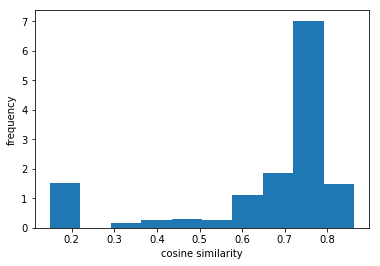

In [39]:
plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()